In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from lib.models import ResNetClassifier, ResBlock
from torch import nn
from lib.data.dataloading import load_nursing
from pathlib import Path
from lib.modules import optimization_loop, evaluate_loop
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from lib.utils import plot_and_save_cm
import seaborn as sns
from tabulate import tabulate


In [3]:
nursing_raw_dir = Path("/home/musa/datasets/nursingv1")
nursing_label_dir = Path("/home/musa/datasets/eating_labels")
DEVICE = 'cuda:1'

In [4]:
winsize = 1001
nursing_trainloader, nursing_testloader = load_nursing(
    nursing_raw_dir, 
    nursing_label_dir, 
    winsize=winsize, 
    # session_idxs=[50, 52],
    # n_sessions=24, 
    test_size=0.5, 
    batch_size=512,
    # shuffle_test=True
)

Using all available sessions: [11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 44, 46, 47, 48, 49, 50, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69]
Train sessions: [44, 64, 31, 47, 17, 25, 26, 61, 48, 37, 23, 58, 28, 68, 57, 66, 69, 20, 63, 42, 38, 41, 11, 27, 52, 21] - total length: 4136000
Test sessions: [32, 14, 62, 29, 46, 50, 56, 39, 33, 54, 36, 49, 19, 18, 59, 13, 67, 60, 22, 53, 40, 30, 16, 12, 24, 65, 35] - total length: 4416000


In [5]:
model = ResNetClassifier(winsize, 3, (8,8,16,32,64,128,256,512)).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.BCEWithLogitsLoss()
print(sum([p.numel() for p in model.parameters() if p.requires_grad]))

10953057


In [6]:
train_loss_batch = []
test_loss_batch = []
confs = []
train_stats = {'loss': [], 'prec': [], 'recall': [], 'f1score': []}
test_stats = {'loss': [], 'prec': [], 'recall': [], 'f1score': []}

In [7]:
# optimization_loop(model, nursing_trainloader, nursing_testloader, criterion, optimizer, 10, DEVICE)

for epoch in range(1):
    model.train()
    for X,y in nursing_trainloader:
        X,y = X.to(DEVICE), y.to(DEVICE)
        logits = model(X)
        loss = criterion(logits, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    
    model.eval()
    loss = 0
    ypred = []
    for X,y in nursing_trainloader:
        X,y = X.to(DEVICE), y.to(DEVICE)
        logits = model(X)
        loss_i = criterion(logits, y).item()
        train_loss_batch.append(loss_i)
        loss += loss_i
        ypred += torch.round(torch.sigmoid(logits.detach().cpu())).tolist()
    train_stats['loss'].append(loss / len(nursing_trainloader))
    prec, recall, f1score, _ = precision_recall_fscore_support(
        nursing_trainloader.dataset.y.squeeze(), 
        ypred, 
        zero_division='warn', pos_label=1, average='binary'
    )
    train_stats['prec'].append(prec)
    train_stats['recall'].append(recall)    
    train_stats['f1score'].append(f1score)


    loss = 0
    test_ypred = []
    for X,y in nursing_testloader:
        X,y = X.to(DEVICE), y.to(DEVICE)
        logits = model(X)
        loss_i = criterion(logits, y).item()
        test_loss_batch.append(loss_i)
        loss += loss_i
        test_ypred += torch.round(torch.sigmoid(logits.detach().cpu())).tolist()
        confs += torch.sigmoid(logits.detach().cpu()).tolist()

    test_stats['loss'].append(loss / len(nursing_testloader))
    prec, recall, f1score, _ = precision_recall_fscore_support(
        nursing_testloader.dataset.y, 
        test_ypred, 
        zero_division=0.0, pos_label=1, average='binary'
    )
    test_stats['prec'].append(prec)
    test_stats['recall'].append(recall)
    test_stats['f1score'].append(f1score)

    torch.save(model.state_dict(), 'dev/test-model.pt')


print("Train\n", tabulate([["Metric", "Value"], *[[k,v] for k,v in train_stats.items()]], headers="firstrow"))
print("\nDev\n", tabulate([["Metric", "Value"], *[[k,v] for k,v in test_stats.items()]], headers="firstrow"))


fig,axes = plt.subplots(1, 3, figsize=(25,10))

axes[0].plot(train_stats['loss'])
axes[0].plot(test_stats['loss'])
axes[0].plot(train_stats['f1score'])
axes[0].plot(test_stats['f1score'])
axes[0].legend(['Train Loss', 'Dev Loss', 'Train F1', 'Dev F1'])
axes[0].set_title('Metrics')

axes[1].plot(train_loss_batch)
axes[1].plot(test_loss_batch)
axes[1].legend(['Train Loss', 'Dev Loss'])

sns.heatmap(confusion_matrix(y_true=nursing_testloader.dataset.y, y_pred=test_ypred), annot=True, ax=axes[2], cbar=False, fmt='.2f')
axes[2].set_title('Dev Confusion Matrix')
axes[2].set(xlabel='Predicted', ylabel='True')
plt.show()

Train
 Metric    Value
--------  ----------------------
loss      [0.031268637798607134]
prec      [0.2254104876864437]
recall    [0.22407926747218526]
f1score   [0.22474290629160598]

Dev
 Metric    Value
--------  ---------------------
loss      [1.3737276524001174]
prec      [0.5565848122805822]
recall    [0.47311060846184416]
f1score   [0.5114642133861783]


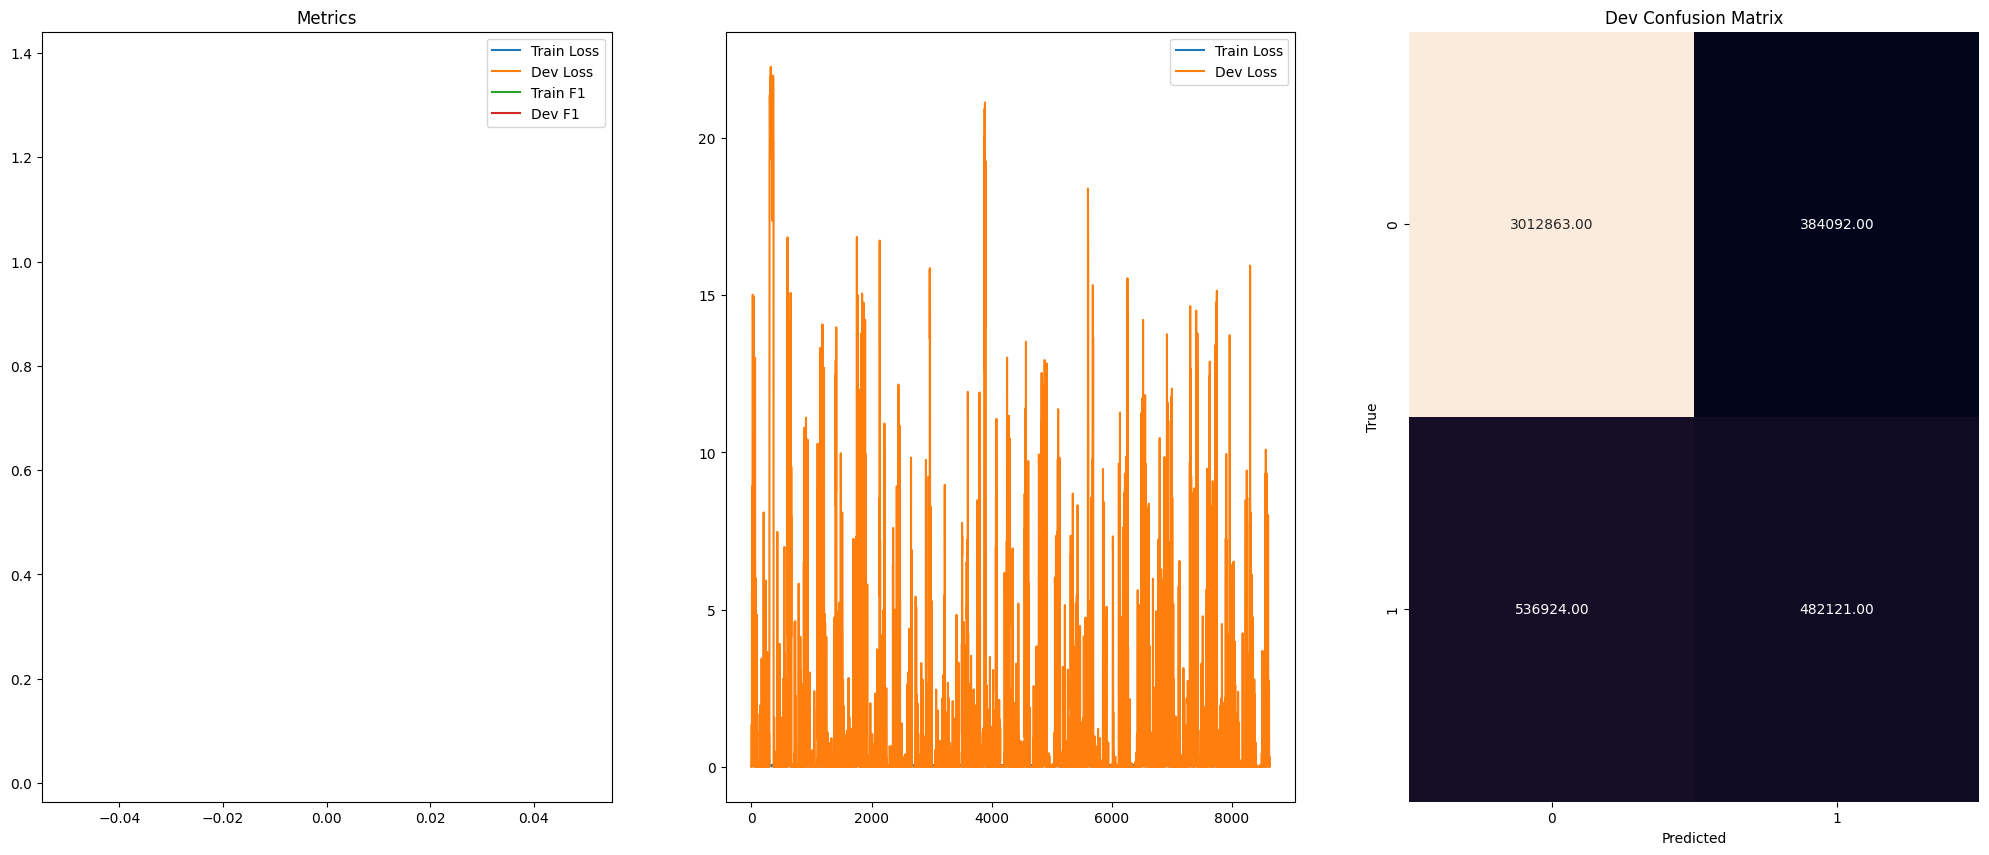

In [61]:

print("Train\n", tabulate([["Metric", "Value"], *[[k,v] for k,v in train_stats.items()]], headers="firstrow"))
print("\nDev\n", tabulate([["Metric", "Value"], *[[k,v] for k,v in test_stats.items()]], headers="firstrow"))


fig,axes = plt.subplots(1, 3, figsize=(25,10))

axes[0].plot(train_stats['loss'])
axes[0].plot(test_stats['loss'])
axes[0].plot(train_stats['f1score'])
axes[0].plot(test_stats['f1score'])
axes[0].legend(['Train Loss', 'Dev Loss', 'Train F1', 'Dev F1'])
axes[0].set_title('Metrics')

axes[1].plot(train_loss_batch)
axes[1].plot(test_loss_batch)
axes[1].legend(['Train Loss', 'Dev Loss'])

sns.heatmap(confusion_matrix(y_true=nursing_testloader.dataset.y, y_pred=test_ypred), annot=True, ax=axes[2], cbar=False, fmt='.2f')
axes[2].set_title('Dev Confusion Matrix')
axes[2].set(xlabel='Predicted', ylabel='True')
plt.show()

In [67]:
test_pred = []
for X,y in nursing_testloader:
    X,y = X.to(DEVICE), y.to(DEVICE)
    logits = model(X)
    test_pred += torch.round(torch.sigmoid(logits.detach().cpu())).tolist()

KeyboardInterrupt: 

In [72]:
ys, stats = evaluate_loop(model.to('cuda:0'), criterion, nursing_testloader, 'cuda:0')

In [73]:
from lib.utils import summary
summary(stats)

Metric        Value
---------  --------
loss       1.37373
precision  0.556585
recall     0.473111
f1         0.511464


In [80]:
from lib.modules import read_nursing_session
import plotly.express as px

df = read_nursing_session(32, nursing_raw_dir)
df['pred'] = ys['pred'][:150000]*10
df['true'] = ys['true'][:150000]*10

fig = px.line(df, x=df.index, y=['x_acc', 'y_acc', 'z_acc', 'pred', 'true'])
fig.show(renderer='browser')

In [79]:
df

,x_acc,y_acc,z_acc,pred,true
0,-0.351807,4.328125,8.937500,0.0,0.0
1,-0.378174,4.578125,8.867188,0.0,0.0
2,-0.469238,4.824219,8.796875,0.0,0.0
3,-0.523926,4.804688,8.742188,0.0,0.0
4,-0.521484,4.816406,8.632812,0.0,0.0
...,...,...,...,...,...
149995,0.648438,2.515625,8.500000,0.0,0.0
149996,0.971680,3.220703,9.156250,0.0,0.0
149997,0.914551,3.552734,10.640625,0.0,0.0
149998,0.272705,4.472656,10.578125,0.0,0.0
